In [105]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt일시.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'

# 2. 특성과 타겟 분리
df_train = df_train.dropna(subset=[target_col])
X = df_train.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])  # 수치형만 사용
y = df_train.loc[X.index, target_col]

# 3. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=62, max_depth=10,
    min_samples_split=2, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)
model.fit(X_train, y_train)

# 6. 훈련 데이터 잔차 기반 분산 계산
log_pred_train = model.regressor_.predict(X_train)
log_true_train = np.log1p(y_train)
residuals = log_true_train - log_pred_train
sigma_sq = np.var(residuals)

# 7. 예측 데이터 불러오기
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        df_pred = pd.read_csv("1234.csv", encoding=enc)
        break
    except:
        continue

# 8. 날짜 처리 및 feature 정비
df_pred['일시'] = pd.to_datetime(df_pred['일시'], errors='coerce')
df_pred = df_pred[(df_pred['일시'] >= '2010-01-01') & (df_pred['일시'] <= '2015-12-31')]

# 누락된 feature를 0으로 채움
features = X.columns.tolist()
for col in features:
    if col not in df_pred.columns:
        df_pred[col] = 0

# 예측용 데이터 준비
X_pred = df_pred[features].copy()
X_pred = X_pred.select_dtypes(include=[np.number])
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).fillna(0)

# 9. 로그 예측 + 분산 보정
X_pred

,최대순간풍속(재해기간),최대풍속(재해기간),평균강수량(재해기간),평균강수량X최대풍속,평균강수량X최대순간풍속(재해기간),평균기온(재해기간),최고기온(재해기간),최저기온(재해기간),순간최대풍속_plus_평균풍속(재해기간),평균풍속(재해기간)_plus_최대풍속(재해기간),최대풍속(재해기간)_plus_최대순간풍속(재해기간),최대풍속(재해기간)_mul_최대순간풍속(재해기간)
0,16.6,12.6,0.0,0.000000,0.000000,3.800,8.075,0.750,19.725,15.725,29.2,14.462365
1,21.8,17.5,0.0,0.000000,0.000000,9.450,15.150,3.750,27.350,23.050,39.3,19.532025
2,22.4,17.6,0.0,0.000000,0.000000,4.775,7.200,2.350,27.050,22.250,40.0,19.855478
3,27.6,21.6,2.1,6.734983,7.613147,7.700,13.500,2.275,34.950,28.950,49.2,24.416388
4,27.0,20.5,1.4,5.357238,6.148170,1.825,4.275,0.775,35.150,28.650,47.5,23.526581
...,...,...,...,...,...,...,...,...,...,...,...,...
2186,21.8,15.9,0.0,0.000000,0.000000,6.750,10.650,4.200,26.325,20.425,37.7,18.617733
2187,20.4,15.0,0.0,0.000000,0.000000,5.575,7.375,3.900,25.650,20.250,35.4,17.492856
2188,17.3,12.0,0.0,0.000000,0.000000,6.425,8.400,4.125,20.625,15.325,29.3,14.408331
2189,12.7,9.6,0.0,0.000000,0.000000,7.500,10.950,4.675,14.850,11.750,22.3,11.041739


In [107]:
log_pred_output = model.regressor_.predict(X_pred)
y_pred_output = np.expm1(log_pred_output + sigma_sq)

# 10. 결과 저장
df_result = df_pred[['일시']].copy()
df_result['예상_재산피해규모(백만원)'] = y_pred_output
df_result['예상_재산피해규모(백만원)'] = df_result['예상_재산피해규모(백만원)']*1.5
df_result.to_csv("예상피해_2010_2015.csv", index=False, encoding='cp949')

# 11. 평가 지표 출력 (선택)
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"✅ 평가 지표:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")

✅ 평가 지표:
MAE : 354.55
RMSE: 591.98
R²  : 0.5368


C:\Users\user\AppData\Local\Temp\ipykernel_27360\3777726353.py:34: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3777726353.py:34: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3777726353.py:34: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3777726353.py:34: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3777726353.py:34: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3777726353.py:34: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

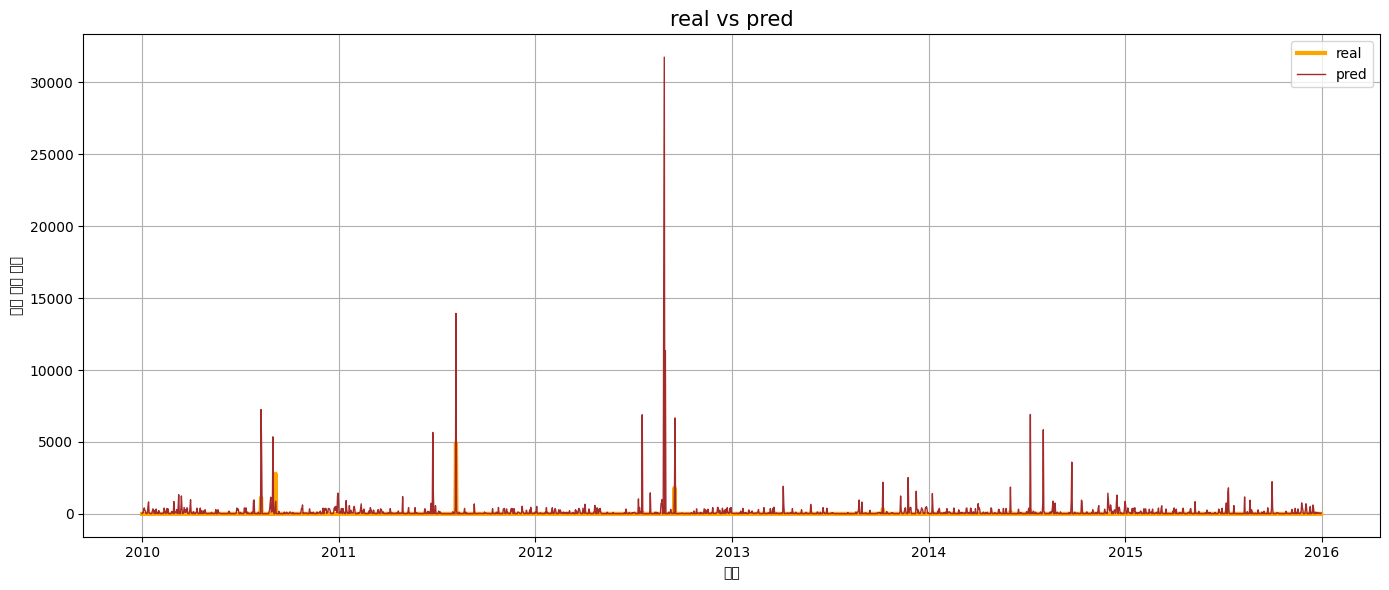

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 불러오기
pred_df = pd.read_csv("예상피해_2010_2015.csv", encoding='cp949')
pred_df['일시'] = pd.to_datetime(pred_df['일시'])


actual_df = pd.read_csv("1234.csv", encoding='cp949')
actual_df['일시'] = pd.to_datetime(actual_df['일시'])

# 2. 실제 피해 컬럼 확인
damage_col = '재산피해규모(백만원)'

# 3. 병합
merged_df = pd.merge(pred_df, actual_df[['일시', damage_col]], on='일시', how='left')
merged_df[damage_col] = merged_df[damage_col].fillna(0)

# 4. 로그 변환
merged_df['pred'] = merged_df['예상_재산피해규모(백만원)']
merged_df['real'] = merged_df[damage_col]

# 5. 시각화 (실제 피해도 선으로 연결)
plt.figure(figsize=(14, 6))
plt.plot(merged_df['일시'], merged_df['real'], label='real', color='orange', linewidth=3)
plt.plot(merged_df['일시'], merged_df['pred'], label='pred', color='brown', linewidth=1)

plt.title('real vs pred', fontsize=15)
plt.xlabel('일시')
plt.ylabel('재산 피해 규모')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        actual_df = pd.read_csv("2021~2025날씨_수정완료.csv", encoding='enc')
        actual_df['일시'] = pd.to_datetime(actual_df['일시'])
        break
    except:
        continue
    

actual_df.describe()


,최대순간풍속(재해기간),최대풍속(재해기간),평균강수량(재해기간),평균강수량X최대풍속,평균강수량X최대순간풍속(재해기간),평균기온(재해기간),최고기온(재해기간),최저기온(재해기간),순간최대풍속_plus_평균풍속(재해기간),평균풍속(재해기간)_plus_최대풍속(재해기간),최대풍속(재해기간)_plus_최대순간풍속(재해기간),최대풍속(재해기간)_mul_최대순간풍속(재해기간),일시,재산피해규모(백만원)
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191,11.000000
mean,15.014377,10.932223,19.019626,6.904074,8.174601,16.038384,19.251757,13.184425,18.812825,14.742446,25.946600,12.793186,2012-12-31 00:00:00,1058.545455
min,4.900000,3.600000,0.000000,0.000000,0.000000,-0.900000,0.875000,-3.275000,0.000000,0.000000,8.500000,4.200000,2010-01-01 00:00:00,3.000000
25%,10.800000,7.200000,0.000000,0.000000,0.000000,9.437500,12.862500,6.175000,13.612500,10.100000,18.000000,8.804544,2011-07-02 12:00:00,123.000000
50%,13.900000,9.800000,0.000000,0.000000,0.000000,16.650000,20.275000,13.525000,17.400000,13.400000,23.600000,11.627553,2012-12-31 00:00:00,214.000000
75%,18.100000,13.500000,5.200000,7.710382,9.195084,22.237500,25.412500,19.975000,22.700000,18.087500,31.700000,15.661417,2014-07-01 12:00:00,1473.500000
max,39.900000,29.900000,751.500000,130.207527,151.687178,30.200000,34.225000,27.425000,52.050000,42.050000,69.800000,34.539977,2015-12-31 00:00:00,4929.000000
std,5.727669,4.699805,57.293238,14.192079,16.790924,7.620847,7.648095,7.909805,7.167208,6.116931,10.347886,5.154349,NaN,1566.351580


In [110]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
features = [col for col in df_train.columns if col != target_col]

# 결측치 제거
df_train = df_train.dropna(subset=[target_col])
X_train = df_train[features].dropna()
y_train = df_train.loc[X_train.index, target_col]

# 2. 모델 학습
rf = RandomForestRegressor(
    n_estimators=62, max_depth=10,
    min_samples_split=2, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)
model.fit(X_train, y_train)

# 3. 예측 데이터 불러오기
# 안전하게 인코딩 확인
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        df_pred = pd.read_csv("1234.csv", encoding=enc)
        break
    except:
        continue

# 날짜 파싱 및 필터링 (일별 전체 대상)
df_pred['일시'] = pd.to_datetime(df_pred['일시'], errors='coerce')
df_pred = df_pred[(df_pred['일시'] >= '2010-01-01') & (df_pred['일시'] <= '2015-12-31')].copy()

# 4. 누락된 feature를 0으로 채우기
for col in features:
    if col not in df_pred.columns:
        df_pred[col] = 0

# 컬럼 순서 일치
X_pred = df_pred[features].copy()

# 무한대/결측치 처리
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).fillna(0)

# 5. 예측 수행
y_pred = model.predict(X_pred)

# 6. 결과 저장 (로그값 저장)
df_result = df_pred[['일시']].copy()
df_result['예상_재산피해규모(백만원)'] = y_pred  # 로그 적용하여 저장
df_result.to_csv("예상피해_2010_2015.csv", index=False, encoding='cp949')



C:\Users\user\AppData\Local\Temp\ipykernel_27360\3537820014.py:35: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3537820014.py:35: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3537820014.py:35: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3537820014.py:35: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3537820014.py:35: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3537820014.py:35: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

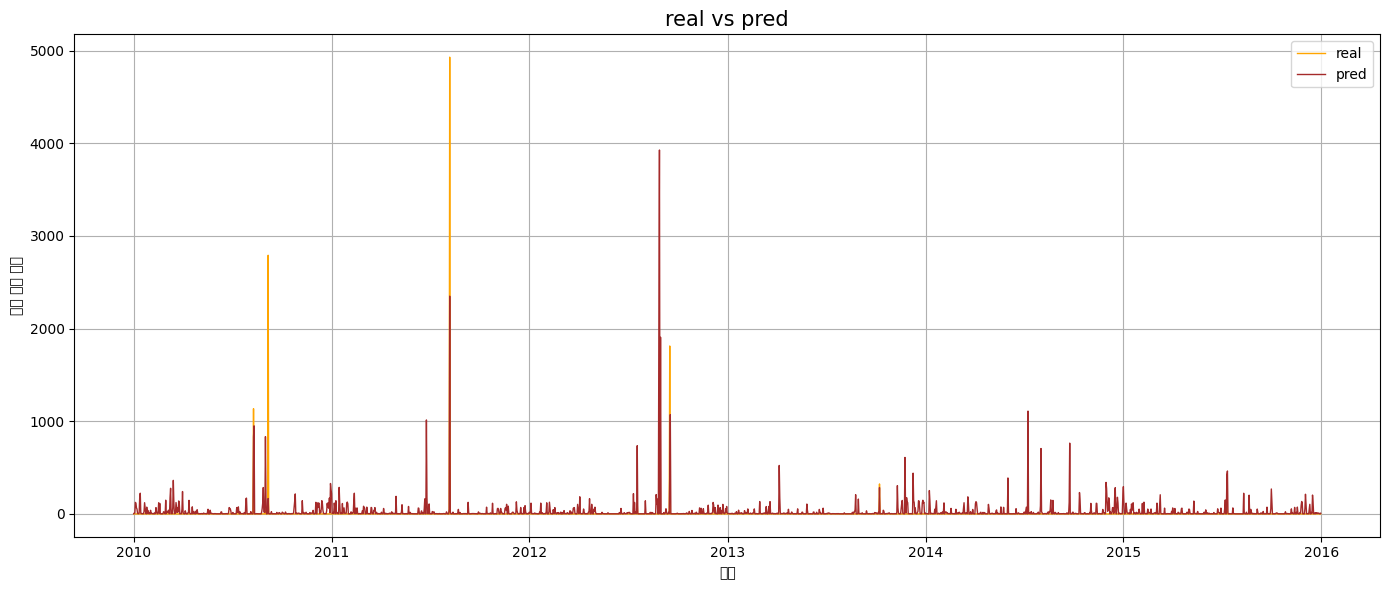

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 불러오기
pred_df = pd.read_csv("예상피해_2010_2015.csv", encoding='cp949')
pred_df['일시'] = pd.to_datetime(pred_df['일시'])

actual_df = pd.read_csv("1234.csv", encoding='cp949')
actual_df['일시'] = pd.to_datetime(actual_df['일시'])

# 2. 실제 피해 컬럼 확인
damage_col = '재산피해규모(백만원)'
if damage_col not in actual_df.columns:
    actual_df[damage_col] = 0

# 3. 병합
merged_df = pd.merge(pred_df, actual_df[['일시', damage_col]], on='일시', how='left')
merged_df[damage_col] = merged_df[damage_col].fillna(0)

# 4. 로그 변환
merged_df['pred'] = merged_df['예상_재산피해규모(백만원)']
merged_df['real'] = merged_df[damage_col]

# 5. 시각화 (실제 피해도 선으로 연결)
plt.figure(figsize=(14, 6))
plt.plot(merged_df['일시'], merged_df['real'], label='real', color='orange', linewidth=1)
plt.plot(merged_df['일시'], merged_df['pred'], label='pred', color='brown', linewidth=1)

plt.title('real vs pred', fontsize=15)
plt.xlabel('일시')
plt.ylabel('재산 피해 규모')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [112]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.compose import TransformedTargetRegressor

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
features = [col for col in df_train.columns if col != target_col]

# 결측치 제거
df_train = df_train.dropna(subset=[target_col])
X_train = df_train[features].dropna()
y_train = df_train.loc[X_train.index, target_col]

# 2. CatBoost 모델 정의
catboost_model = CatBoostRegressor(
    learning_rate=0.2,
    depth=6,
    l2_leaf_reg=5,
    iterations=100,
    subsample=0.9,
    random_strength=1,
    verbose=0,             # 로그 출력 억제
    random_state=42
)

model = TransformedTargetRegressor(
    regressor=catboost_model,
    func=np.log1p,
    inverse_func=np.expm1
)

model.fit(X_train, y_train)

# 3. 예측 데이터 로딩 (인코딩 자동 탐색)
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        df_pred = pd.read_csv("1234", encoding=enc)
        break
    except:
        continue

# 4. 날짜 필터링
df_pred['일시'] = pd.to_datetime(df_pred['일시'], errors='coerce')
df_pred = df_pred[(df_pred['일시'] >= '2010-01-01') & (df_pred['일시'] <= '2015-12-31')].copy()

# 5. 누락된 feature 보완
for col in features:
    if col not in df_pred.columns:
        df_pred[col] = 0
X_pred = df_pred[features].copy()

# 6. 결측값/무한값 처리
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).fillna(0)

# 7. 예측
y_pred = model.predict(X_pred)

# 8. 결과 저장 (로그값 저장)
df_result = df_pred[['일시']].copy()
df_result['예상_재산피해규모(백만원)'] = y_pred
df_result.to_csv("예상피해_2010_2015전체CatBoost.csv", index=False, encoding='cp949')


C:\Users\user\AppData\Local\Temp\ipykernel_18640\3213290656.py:36: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\3213290656.py:36: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\3213290656.py:36: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\3213290656.py:36: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\3213290656.py:36: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\3213290656.py:36: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

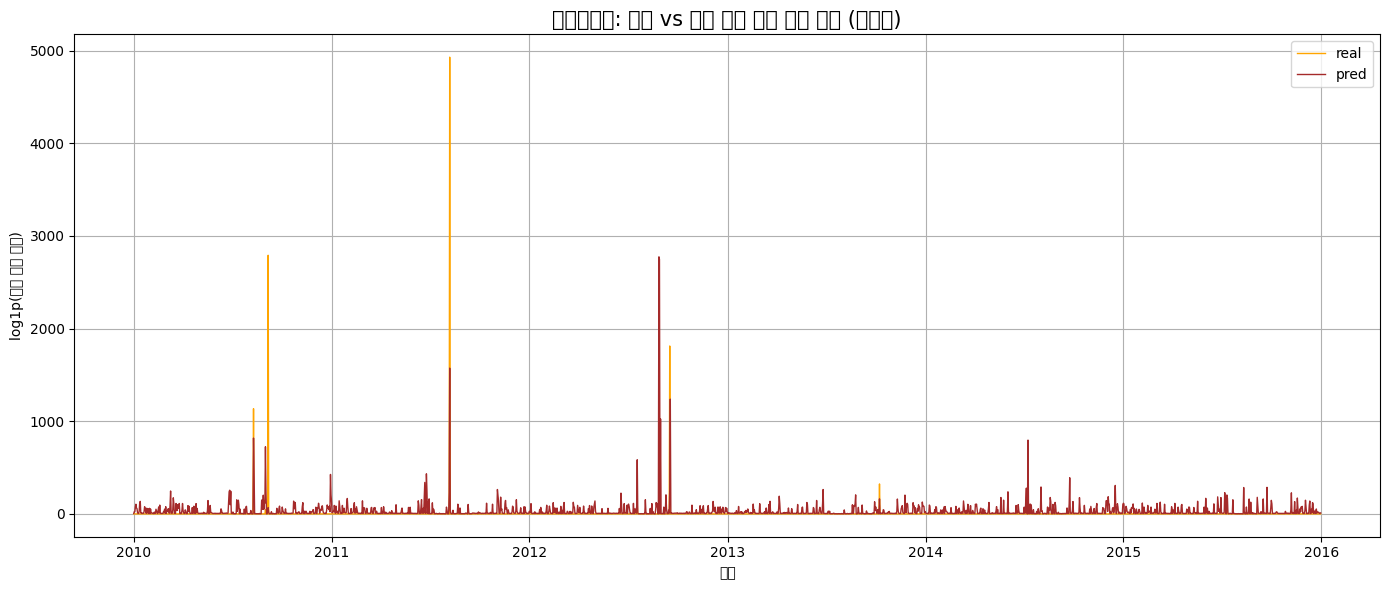

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 불러오기
pred_df = pd.read_csv("예상피해_2010_2015전체CatBoost.csv", encoding='cp949')
pred_df['일시'] = pd.to_datetime(pred_df['일시'])

actual_df = pd.read_csv("1234.csv", encoding='cp949')
actual_df['일시'] = pd.to_datetime(actual_df['일시'])

# 2. 실제 피해 컬럼 확인
damage_col = '재산피해규모(백만원)'
if damage_col not in actual_df.columns:
    actual_df[damage_col] = 0

# 3. 병합
merged_df = pd.merge(pred_df, actual_df[['일시', damage_col]], on='일시', how='left')
merged_df[damage_col] = merged_df[damage_col].fillna(0)

# 4. 로그 변환
merged_df['pred'] = merged_df['예상_재산피해규모(백만원)']

merged_df['real'] = merged_df[damage_col]

# 5. 시각화 (실제 피해도 선으로 연결)
plt.figure(figsize=(14, 6))
plt.plot(merged_df['일시'], merged_df['real'], label='real', color='orange', linewidth=1)
plt.plot(merged_df['일시'], merged_df['pred'], label='pred', color='brown', linewidth=1)

plt.title('로그스케일: 실제 vs 예측 태풍 재산 피해 규모 (연결선)', fontsize=15)
plt.xlabel('일시')
plt.ylabel('log1p(재산 피해 규모)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import TweedieRegressor
from sklearn.compose import TransformedTargetRegressor

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
features = [col for col in df_train.columns if col != target_col]

# 결측치 제거
df_train = df_train.dropna(subset=[target_col])
X_train = df_train[features].dropna()
y_train = df_train.loc[X_train.index, target_col]

# 2. Tweedie Regressor 정의
from sklearn.linear_model import TweedieRegressor

tweedie_model = TweedieRegressor(
    power=1.5,
    alpha=0.1,
    link='log',
    max_iter=1000
)


# 3. 모델 학습 (로그 변환 불필요 — 링크 함수 자체가 log임)
model = tweedie_model
model.fit(X_train, y_train)

# 4. 예측 데이터 불러오기 (인코딩 자동 탐색)
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        df_pred = pd.read_csv("1234", encoding=enc)
        break
    except:
        continue

# 5. 날짜 필터링
df_pred['일시'] = pd.to_datetime(df_pred['일시'], errors='coerce')
df_pred = df_pred[(df_pred['일시'] >= '2010-01-01') & (df_pred['일시'] <= '2015-12-31')].copy()

# 6. 누락된 feature 보완
for col in features:
    if col not in df_pred.columns:
        df_pred[col] = 0
X_pred = df_pred[features].copy()

# 7. 결측값/무한값 처리
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).fillna(0)

# 8. 예측
y_pred = model.predict(X_pred)

# 9. 결과 저장 (원 단위 저장)
df_result = df_pred[['일시']].copy()
df_result['예상_재산피해규모(백만원)'] = y_pred
df_result.to_csv("예상피해_2010_2015전체_Tweedie.csv", index=False, encoding='cp949')


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


C:\Users\user\AppData\Local\Temp\ipykernel_18640\2609959628.py:36: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2609959628.py:36: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2609959628.py:36: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2609959628.py:36: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2609959628.py:36: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2609959628.py:36: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

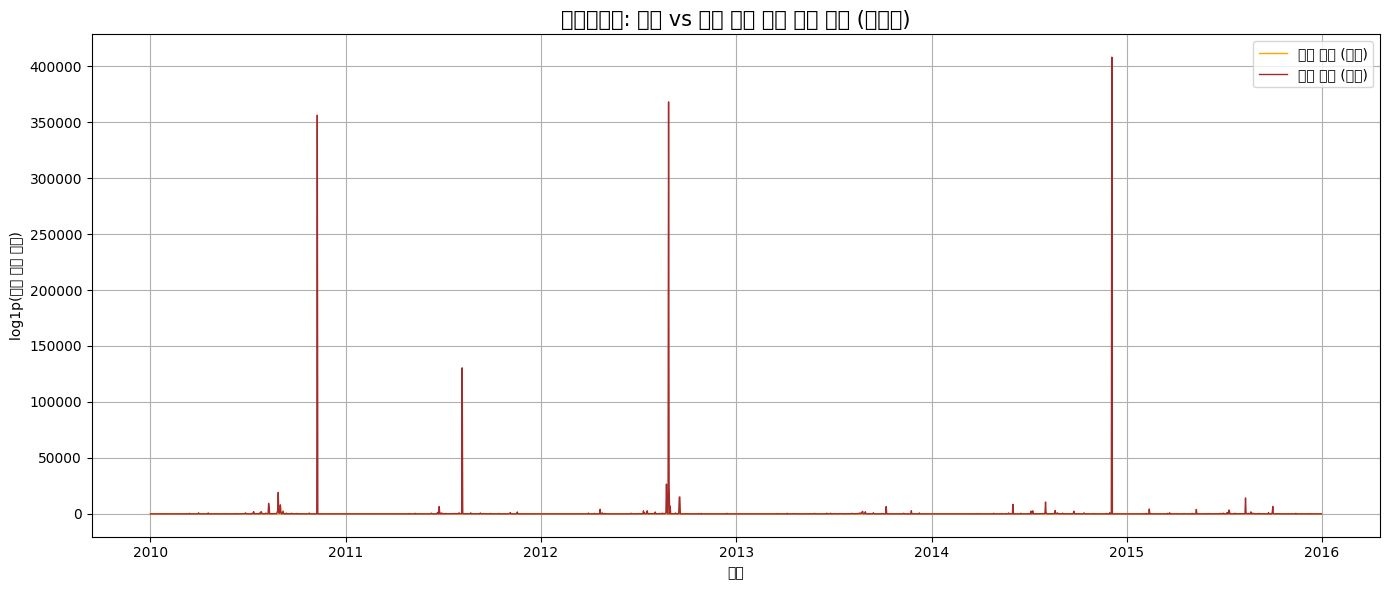

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 불러오기
pred_df = pd.read_csv("예상피해_2010_2015전체_Tweedie.csv", encoding='cp949')
pred_df['일시'] = pd.to_datetime(pred_df['일시'])

actual_df = pd.read_csv("1234.csv", encoding='cp949')
actual_df['일시'] = pd.to_datetime(actual_df['일시'])

# 2. 실제 피해 컬럼 확인
damage_col = '재산피해규모(백만원)'
if damage_col not in actual_df.columns:
    actual_df[damage_col] = 0

# 3. 병합
merged_df = pd.merge(pred_df, actual_df[['일시', damage_col]], on='일시', how='left')
merged_df[damage_col] = merged_df[damage_col].fillna(0)

# 4. 로그 변환
merged_df['예측_로그'] = merged_df['예상_재산피해규모(백만원)']

merged_df['실제_로그'] = merged_df[damage_col]

# 5. 시각화 (실제 피해도 선으로 연결)
plt.figure(figsize=(14, 6))
plt.plot(merged_df['일시'], merged_df['실제_로그'], label='실제 피해 (로그)', color='orange', linewidth=1)
plt.plot(merged_df['일시'], merged_df['예측_로그'], label='예측 피해 (로그)', color='brown', linewidth=1)

plt.title('로그스케일: 실제 vs 예측 태풍 재산 피해 규모 (연결선)', fontsize=15)
plt.xlabel('일시')
plt.ylabel('log1p(재산 피해 규모)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
features = [col for col in df_train.columns if col != target_col]

# 결측치 제거
df_train = df_train.dropna(subset=[target_col])
X_train = df_train[features].dropna()
y_train = df_train.loc[X_train.index, target_col]

# 2. Huber 모델 정의 (스케일러 포함)
model = make_pipeline(
    StandardScaler(),
    HuberRegressor(epsilon=1.35, max_iter=1000)
)

# 3. 모델 학습
model.fit(X_train, y_train)

# 4. 예측 데이터 로딩 (인코딩 자동 탐색)
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        df_pred = pd.read_csv("1234", encoding=enc)
        break
    except:
        continue

# 5. 날짜 필터링
df_pred['일시'] = pd.to_datetime(df_pred['일시'], errors='coerce')
df_pred = df_pred[(df_pred['일시'] >= '2010-01-01') & (df_pred['일시'] <= '2015-12-31')].copy()

# 6. 누락된 feature 보완
for col in features:
    if col not in df_pred.columns:
        df_pred[col] = 0
X_pred = df_pred[features].copy()

# 7. 결측값/무한값 처리
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).fillna(0)

# 8. 예측
y_pred = model.predict(X_pred)

# 9. 결과 저장
df_result = df_pred[['일시']].copy()
df_result['예상_재산피해규모(백만원)_로그'] = y_pred
df_result.to_csv("예상피해_2010_2015전체_Huber.csv", index=False, encoding='cp949')


C:\Users\user\AppData\Local\Temp\ipykernel_18640\473277592.py:39: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\473277592.py:39: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\473277592.py:39: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\473277592.py:39: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\473277592.py:39: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\473277592.py:39: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s) DejaV

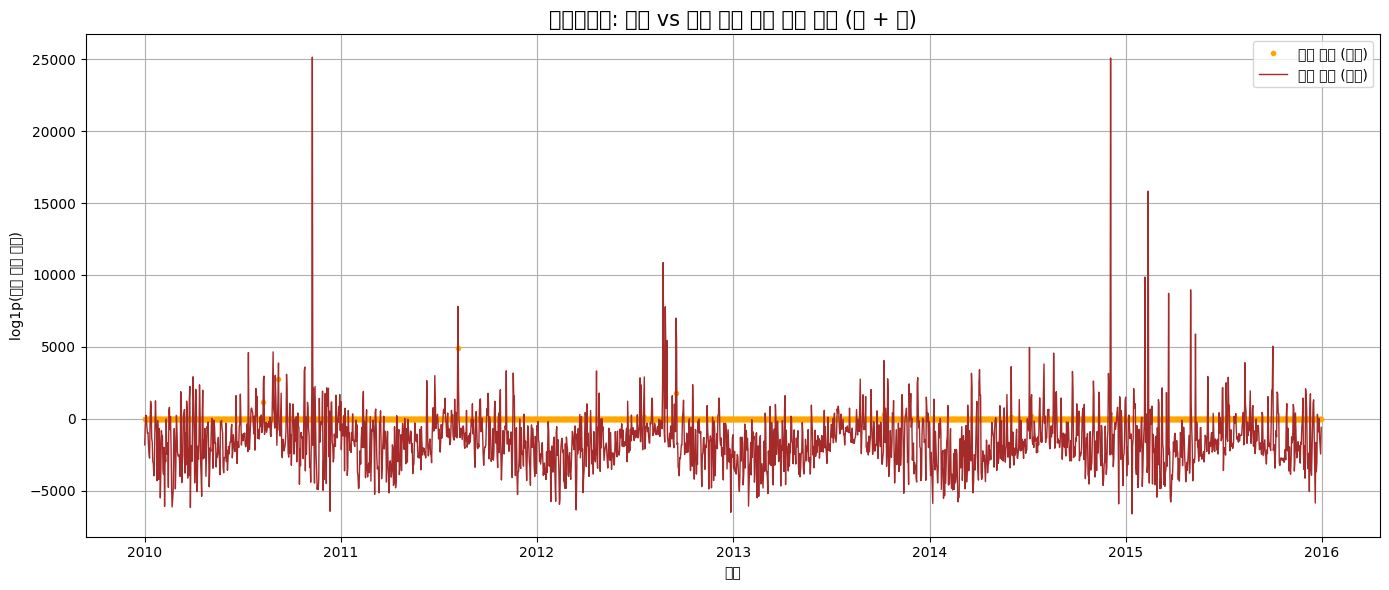

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 불러오기
pred_df = pd.read_csv("예상피해_2010_2015전체_Huber.csv", encoding='cp949')
pred_df['일시'] = pd.to_datetime(pred_df['일시'])

actual_df = pd.read_csv("1234.csv", encoding='cp949')
actual_df['일시'] = pd.to_datetime(actual_df['일시'])

# 2. 실제 피해 컬럼 확인
damage_col = '재산피해규모(백만원)'
if damage_col not in actual_df.columns:
    actual_df[damage_col] = 0

# 3. 병합
merged_df = pd.merge(pred_df, actual_df[['일시', damage_col]], on='일시', how='left')
merged_df[damage_col] = merged_df[damage_col].fillna(0)

# 4. 로그 변환
merged_df['예측_로그'] = merged_df['예상_재산피해규모(백만원)_로그']
merged_df['실제_로그'] = merged_df[damage_col]

# 5. 시각화 (실제 피해는 점, 예측은 선)
plt.figure(figsize=(14, 6))

# 실제 피해: 점 그래프 (꺾이지 않음)
plt.plot(merged_df['일시'], merged_df['실제_로그'], 'o', label='실제 피해 (로그)', color='orange', markersize=3)

# 예측 피해: 선 그래프
plt.plot(merged_df['일시'], merged_df['예측_로그'], label='예측 피해 (로그)', color='brown', linewidth=1)

plt.title('로그스케일: 실제 vs 예측 태풍 재산 피해 규모 (점 + 선)', fontsize=15)
plt.xlabel('일시')
plt.ylabel('log1p(재산 피해 규모)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

# 1. 학습 데이터 불러오기
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        df_train = pd.read_csv("1234.csv", encoding=enc)
        break
    except:
        continue

# 대상 컬럼
target_col = '재산피해규모(백만원)'

# 결측치 제거
df_train = df_train.dropna(subset=[target_col])

# 문자열 컬럼 제거 (특히 '일시' 포함)
X_train = df_train.drop(columns=[target_col])
X_train = X_train.select_dtypes(include=[np.number])  # 수치형만 유지
y_train = df_train.loc[X_train.index, target_col]

# feature 목록 저장 (예측에도 동일하게 사용)
features = X_train.columns.tolist()

# 2. 모델 학습
rf = RandomForestRegressor(
    n_estimators=100, max_depth=10,
    min_samples_split=2, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)

model.fit(X_train, y_train)

# 3. 예측 데이터 불러오기
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        df_pred = pd.read_csv("1234.csv", encoding=enc)
        break
    except:
        continue

# 날짜 처리 및 필터링
df_pred['일시'] = pd.to_datetime(df_pred['일시'], errors='coerce')
df_pred = df_pred[(df_pred['일시'] >= '2010-01-01') & (df_pred['일시'] <= '2015-12-31')].copy()

# 누락된 feature 보완
for col in features:
    if col not in df_pred.columns:
        df_pred[col] = 0

# 예측 입력용 데이터 생성
X_pred = df_pred[features].copy()
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).fillna(0)

# 4. 예측 수행
y_pred = model.predict(X_pred)

# 5. 결과 저장
df_result = df_pred[['일시']].copy()
df_result['예상_재산피해규모(백만원)'] = y_pred
df_result.to_csv("예상피해_2010_2015.csv", index=False, encoding='cp949')


C:\Users\user\AppData\Local\Temp\ipykernel_18640\2908114855.py:42: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2908114855.py:42: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2908114855.py:42: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2908114855.py:42: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2908114855.py:42: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_18640\2908114855.py:42: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

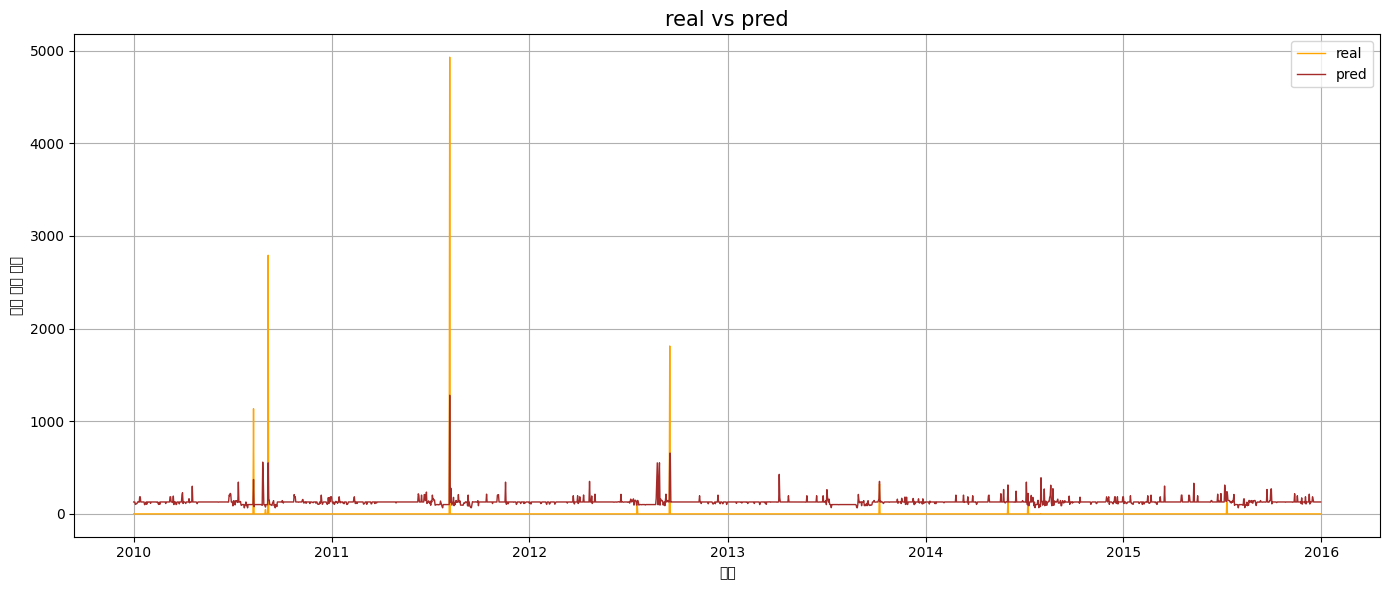

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 불러오기
pred_df = pd.read_csv("예상피해_2010_2015.csv", encoding='cp949')
pred_df['일시'] = pd.to_datetime(pred_df['일시'])

# 1. 학습 데이터 불러오기
for enc in ['cp949', 'euc-kr', 'utf-8', 'ISO-8859-1']:
    try:
        actual_df = pd.read_csv("1234.csv", encoding=enc)
        break
    except:
        continue

actual_df['일시'] = pd.to_datetime(actual_df['일시'])

# 2. 실제 피해 컬럼 확인
damage_col = '재산피해규모(백만원)'
if damage_col not in actual_df.columns:
    actual_df[damage_col] = 0

# 3. 병합
merged_df = pd.merge(pred_df, actual_df[['일시', damage_col]], on='일시', how='left')
merged_df[damage_col] = merged_df[damage_col].fillna(0)

# 4. 로그 변환
merged_df['pred'] = merged_df['예상_재산피해규모(백만원)']
merged_df['real'] = merged_df[damage_col]

# 5. 시각화 (실제 피해도 선으로 연결)
plt.figure(figsize=(14, 6))
plt.plot(merged_df['일시'], merged_df['real'], label='real', color='orange', linewidth=1)
plt.plot(merged_df['일시'], merged_df['pred'], label='pred', color='brown', linewidth=1)

plt.title('real vs pred', fontsize=15)
plt.xlabel('일시')
plt.ylabel('재산 피해 규모')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import product
from tqdm import tqdm

# 1. 데이터 로드 및 전처리
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
df_train = df_train.dropna(subset=[target_col])
X = df_train.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])
y = df_train.loc[X.index, target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 세분화된 하이퍼파라미터 후보군
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

# 조합 생성
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf']
))

results = []

# 3. 모든 조합에 대해 학습 및 평가 (진행률 포함)
for n, d, s, l in tqdm(param_combinations, desc="💡 탐색 중..."):
    rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=d,
        min_samples_split=s,
        min_samples_leaf=l,
        random_state=42,
        n_jobs=-1
    )
    model = TransformedTargetRegressor(
        regressor=rf,
        func=np.log1p,
        inverse_func=np.expm1
    )
    model.fit(X_train, y_train)

    # 분산 보정
    log_pred_train = model.regressor_.predict(X_train)
    log_true_train = np.log1p(y_train)
    sigma_sq = np.var(log_true_train - log_pred_train)

    # 예측
    y_pred_test = np.expm1(model.regressor_.predict(X_test) + sigma_sq)

    # 성능 평가
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    # 저장
    results.append({
        'n_estimators': n,
        'max_depth': d,
        'min_samples_split': s,
        'min_samples_leaf': l,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# 4. 결과 DataFrame 생성
results_df = pd.DataFrame(results)

# 5. 기준별 최적 조합 추출
best_mae = results_df.loc[results_df['MAE'].idxmin()]
best_rmse = results_df.loc[results_df['RMSE'].idxmin()]
best_r2 = results_df.loc[results_df['R2'].idxmax()]

summary_df = pd.DataFrame([
    {'기준': 'MAE 최소', **best_mae.to_dict()},
    {'기준': 'RMSE 최소', **best_rmse.to_dict()},
    {'기준': 'R2 최대', **best_r2.to_dict()}
])

# 6. 결과 저장
summary_df.to_csv("랜덤포레스트_최적파라미터_비교 tt꺼꺼.csv", index=False, encoding='cp949')
print("📁 결과 저장 완료: 랜덤포레스트_최적파라미터_비교.csv")


💡 탐색 중...: 100%|██████████| 108/108 [00:32<00:00,  3.33it/s]

📁 결과 저장 완료: 랜덤포레스트_최적파라미터_비교.csv


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split

# 1. 학습 데이터 로드 및 전처리
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
df_train = df_train.dropna(subset=[target_col])
X = df_train.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])
y = df_train.loc[X.index, target_col]

# 2. 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. 모델 정의 및 학습
rf = RandomForestRegressor(
    n_estimators=100, max_depth=15,
    min_samples_split=2, min_samples_leaf=1,
    random_state=42, n_jobs=-1
)
model = TransformedTargetRegressor(regressor=rf, func=np.log1p, inverse_func=np.expm1)
model.fit(X_train, y_train)

# 4. 로그 잔차 기반 분산 계산 (정규성 가정 하의 기대값 보정용)
log_pred_train = model.regressor_.predict(X_train)
log_true_train = np.log1p(y_train)
residuals = log_true_train - log_pred_train
sigma_sq = np.var(residuals)


# 5. 전체 예측 대상 데이터 로드 (2000~2023)
df_full = pd.read_csv("tt일시지운거.csv", encoding='cp949')
df_full['일시'] = pd.to_datetime(df_full['일시'], errors='coerce')

# 6. 전체 날짜 생성 및 병합
all_dates = pd.date_range(start='2000-01-01', end='2023-12-31')
df_all = pd.DataFrame({'일시': all_dates})
df_merged = pd.merge(df_all, df_full, on='일시', how='left')

# 7. 예측용 feature 정비
features = X.columns.tolist()
for col in features:
    if col not in df_merged.columns:
        df_merged[col] = 0
X_pred = df_merged[features].replace([np.inf, -np.inf], np.nan).fillna(0)

# 8. 예측 수행
log_pred = model.regressor_.predict(X_pred)
y_pred = np.expm1(log_pred + sigma_sq)

# ✅ 8-1. 태풍 없는 날은 0으로 덮어쓰기
# 기준: '재산피해규모(백만원)' 컬럼이 NaN이면 태풍 없음
y_pred[df_merged['재산피해규모(백만원)'].isna()] = 0

# 9. 결과 저장
df_result = df_merged[['일시']].copy()
df_result['예상_재산피해규모(백만원)'] = y_pred
df_result.to_csv("예상피해_모델기반_2000_2023.csv", index=False, encoding='cp949')

# ✅ 10. 실제 피해값도 날짜에 맞춰 병합
real_damage = df_full[['일시', '재산피해규모(백만원)']].copy()
real_damage = real_damage.rename(columns={'재산피해규모(백만원)': '실제_재산피해규모(백만원)'})

# df_result와 날짜 기준 병합
df_result = pd.merge(df_result, real_damage, on='일시', how='left')

# 피해 없는 날은 0으로
df_result['실제_재산피해규모(백만원)'] = df_result['실제_재산피해규모(백만원)'].fillna(0)

# ✅ 저장
df_result.to_csv("예상_실제_피해_통합_2000_2023.csv", index=False, encoding='cp949')





C:\Users\user\AppData\Local\Temp\ipykernel_27360\3883194893.py:17: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3883194893.py:17: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3883194893.py:17: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3883194893.py:17: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3883194893.py:17: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3883194893.py:17: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

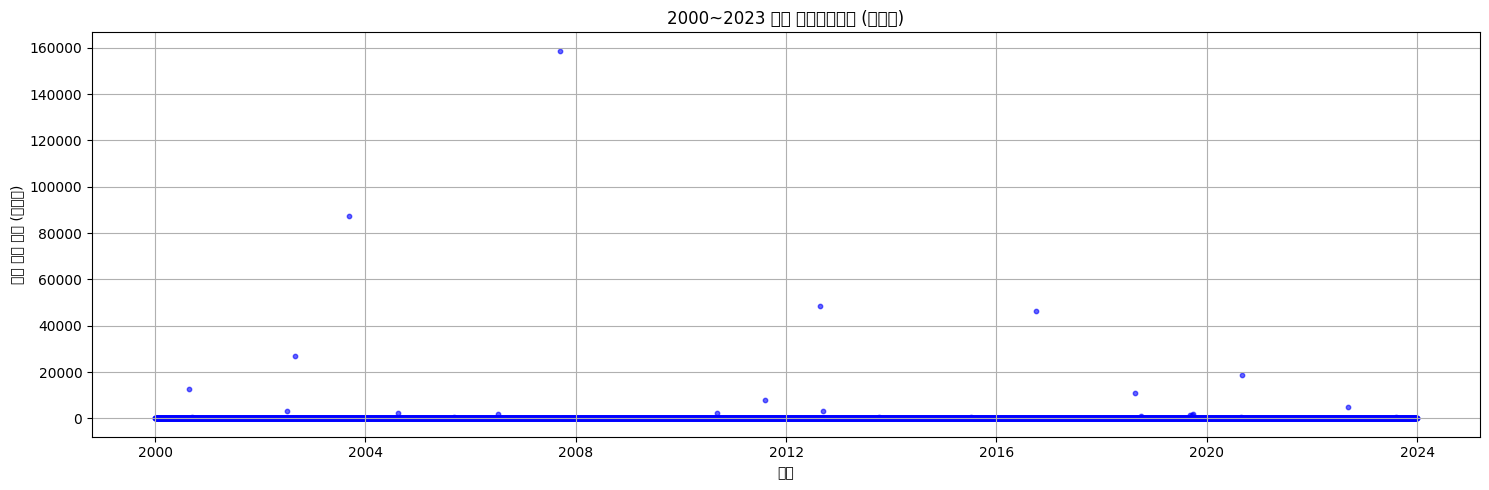

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 불러오기
df = pd.read_csv("예상피해_모델기반_2000_2023.csv", encoding='cp949')

# 날짜 컬럼 datetime 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'])

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.scatter(df['일시'], df['예상_재산피해규모(백만원)'], color='blue', s=10, alpha=0.6)
plt.title('2000~2023 예상 재산피해규모 (백만원)')
plt.xlabel('일시')
plt.ylabel('예상 피해 규모 (백만원)')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_27360\3229447758.py:34: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3229447758.py:34: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3229447758.py:34: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3229447758.py:34: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3229447758.py:34: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3229447758.py:34: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

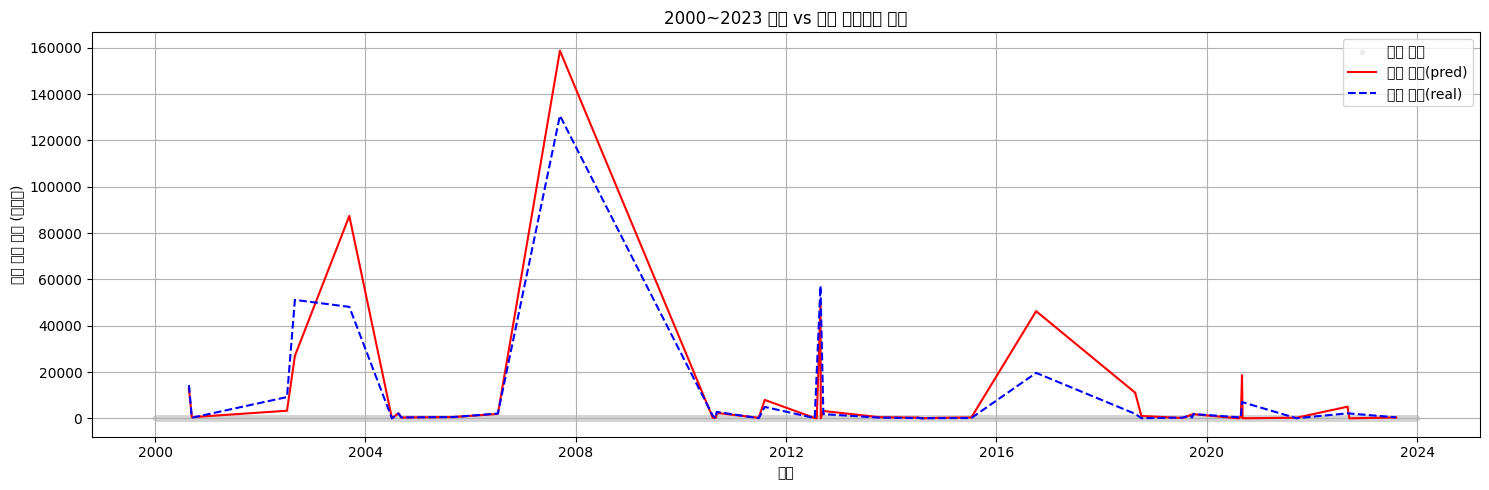

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CSV 불러오기
df = pd.read_csv("예상_실제_피해_통합_2000_2023.csv", encoding='cp949')

# 2. 날짜 컬럼 변환
df['일시'] = pd.to_datetime(df['일시'])

# ✅ 3. 예측값과 실제값 모두 0보다 큰 행만 따로 필터링
df_pred = df[df['예상_재산피해규모(백만원)'] > 0]
df_real = df[df['실제_재산피해규모(백만원)'] > 0]

# 4. 그래프 그리기
plt.figure(figsize=(15, 5))

# 전체 점 (배경용)
plt.scatter(df['일시'], df['예상_재산피해규모(백만원)'], color='lightgray', s=10, alpha=0.3, label='예측 전체')

# 예측 선
plt.plot(df_pred['일시'], df_pred['예상_재산피해규모(백만원)'],
         color='red', linewidth=1.5, label='예측 피해(pred)')

# 실제 선
plt.plot(df_real['일시'], df_real['실제_재산피해규모(백만원)'],
         color='blue', linewidth=1.5, label='실제 피해(real)', linestyle='--')

# 설정
plt.title('2000~2023 실제 vs 예측 재산피해 비교')
plt.xlabel('일시')
plt.ylabel('재산 피해 규모 (백만원)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_27360\3717565942.py:17: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3717565942.py:17: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3717565942.py:17: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3717565942.py:17: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3717565942.py:17: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\3717565942.py:17: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

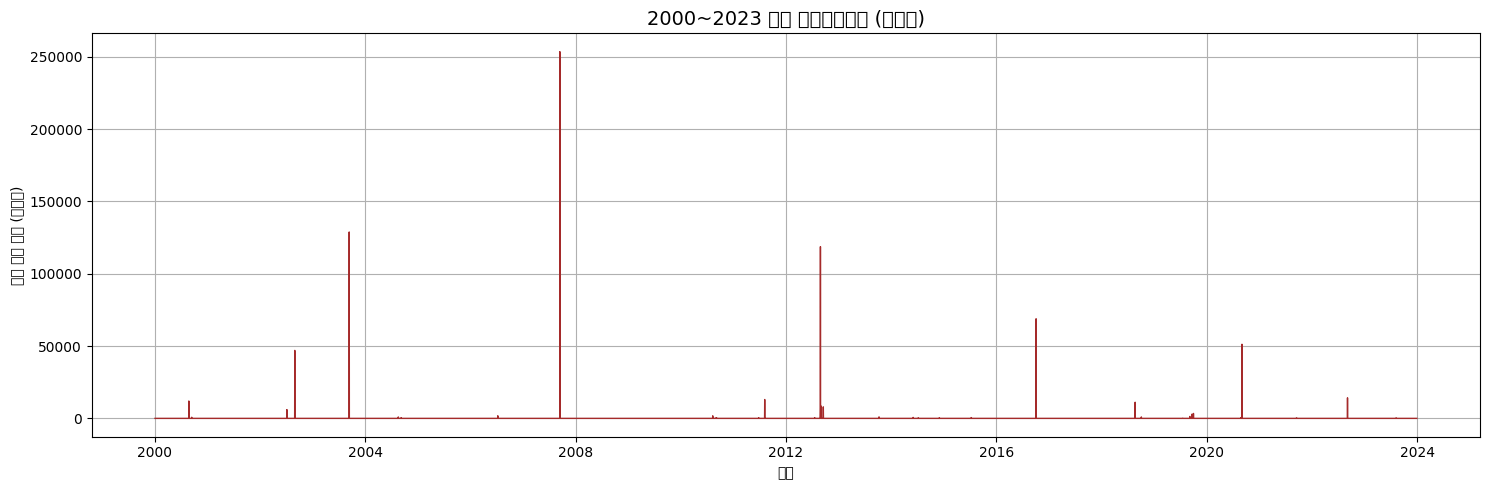

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 불러오기
df = pd.read_csv("예상피해_모델기반_2000_2023.csv", encoding='cp949')

# 날짜 컬럼을 datetime 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'])

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(df['일시'], df['예상_재산피해규모(백만원)'], color='brown', linewidth=1)
plt.title('2000~2023 예상 재산피해규모 (백만원)', fontsize=14)
plt.xlabel('일시')
plt.ylabel('예상 피해 규모 (백만원)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split

# 1. 학습 데이터 로드 및 전처리
df_train = pd.read_csv("tt일시지운거.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
df_train = df_train.dropna(subset=[target_col])
X = df_train.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])
y = df_train.loc[X.index, target_col]

# 6. 전체 날짜 생성 및 병합
all_dates = pd.date_range(start='2000-01-01', end='2023-12-31')
df_all = pd.DataFrame({'일시': all_dates})
df_merged = pd.merge(df_all, df_full, on='일시', how='left')


# ✅ 8-1. 태풍 없는 날은 0으로 덮어쓰기
# 기준: '재산피해규모(백만원)' 컬럼이 NaN이면 태풍 없음
y[df_merged['재산피해규모(백만원)'].isna()] = 0

# 9. 결과 저장
df_result = df_merged[['일시']].copy()
df_result['실제재산피해규모(백만원)'] = y
df_result.to_csv("실제 피해액_2000_2023.csv", index=False, encoding='cp949')

C:\Users\user\AppData\Local\Temp\ipykernel_27360\1661260957.py:25: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\1661260957.py:25: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\1661260957.py:25: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\1661260957.py:25: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\1661260957.py:25: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_27360\1661260957.py:25: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from font(s)

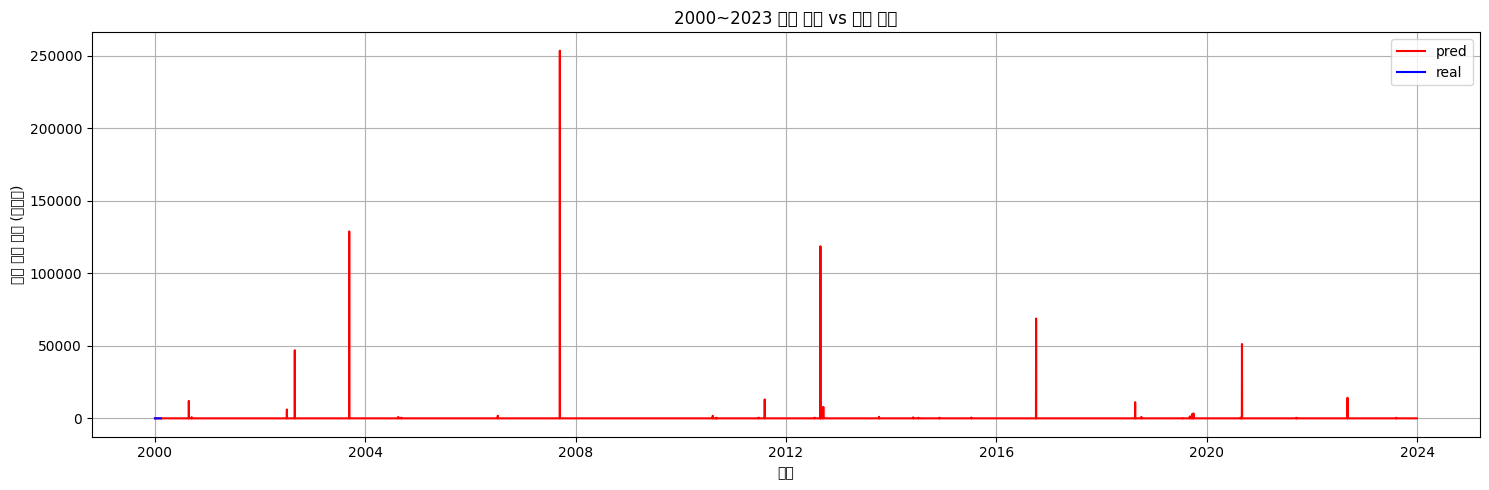

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 불러오기
df_real = pd.read_csv("실제 피해액_2000_2023.csv", encoding='cp949')
df_pred = pd.read_csv("예상피해_모델기반_2000_2023.csv", encoding='cp949')

# 날짜 컬럼 변환
df_real['일시'] = pd.to_datetime(df_real['일시'])
df_pred['일시'] = pd.to_datetime(df_pred['일시'])

# 그래프용 병합 (날짜 기준)
df_merged = pd.merge(df_real, df_pred, on='일시', how='inner')

# 그래프
plt.figure(figsize=(15, 5))
plt.plot(df_merged['일시'], df_merged['예상_재산피해규모(백만원)'], color='red', label='pred')  # 예측
plt.plot(df_merged['일시'], df_merged['실제재산피해규모(백만원)'], color='blue', label='real')  # 실제

plt.title('2000~2023 실제 피해 vs 예측 피해')
plt.xlabel('일시')
plt.ylabel('재산 피해 규모 (백만원)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'

# 2. 특성과 타겟 분리
df_train = df_train.dropna(subset=[target_col])
X = df_train.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])  # 수치형만 사용
y = df_train.loc[X.index, target_col]

# 3. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. 모델 정의 및 학습
rf = RandomForestRegressor(
    n_estimators=62,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)
model.fit(X_train, y_train)

# 5. 훈련 데이터 잔차 기반 분산 계산
log_pred_train = model.regressor_.predict(X_train)
log_true_train = np.log1p(y_train)
residuals = log_true_train - log_pred_train
sigma_sq = np.var(residuals)



# 6. 테스트셋 예측 및 평가 지표 계산
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # ✅ 수정된 부분
r2 = r2_score(y_test, y_pred)

# 7. 출력
print(f"✅ 평가 지표:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")
print(f"🔍 훈련 데이터 잔차 분산 (log scale): {sigma_sq:.4f}")


✅ 평가 지표:
MAE : 354.55
RMSE: 591.98
R²  : 0.5368
🔍 훈련 데이터 잔차 분산 (log scale): 1.3627


In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("newtt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'

# 2. 특성과 타겟 분리
df_train = df_train.dropna(subset=[target_col])
X = df_train.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])  # 수치형만 사용
y = df_train.loc[X.index, target_col]

# 3. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. 모델 정의 및 학습
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)
model.fit(X_train, y_train)

# 5. 훈련 데이터 잔차 기반 분산 계산
log_pred_train = model.regressor_.predict(X_train)
log_true_train = np.log1p(y_train)
residuals = log_true_train - log_pred_train
sigma_sq = np.var(residuals)

# 6. 테스트셋 예측 및 평가 지표 계산
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # ✅ 수정된 부분
r2 = r2_score(y_test, y_pred)

# 7. 출력
print(f"✅ 평가 지표:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")
print(f"🔍 훈련 데이터 잔차 분산 (log scale): {sigma_sq:.4f}")


✅ 평가 지표:
MAE : 1096.57
RMSE: 1599.32
R²  : 0.3555
🔍 훈련 데이터 잔차 분산 (log scale): 0.6133


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

# 1. 학습 데이터 로드
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
df_train = df_train.dropna(subset=[target_col])

# 2. 학습 데이터 전처리
features = [col for col in df_train.columns if col != target_col]
X = df_train[features].dropna()
y = df_train.loc[X.index, target_col]

# 3. 모델 정의 및 학습
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)

model.fit(X, y)

# 4. 예측 대상 데이터 로드
df_pred = pd.read_csv("1234.csv", encoding='cp949')

# 5. 날짜 필터링
df_pred['일시'] = pd.to_datetime(df_pred['일시'], errors='coerce')
df_pred = df_pred[(df_pred['일시'] >= '2010-01-01') & (df_pred['일시'] <= '2015-12-31')]
df_pred = df_pred.dropna()

# 6. 예측
X_pred = df_pred[features].copy()
y_pred = model.predict(X_pred)

# 7. 결과 저장
df_result = df_pred[['일시']].copy()
df_result['예상_재산피해규모(백만원)'] = y_pred
df_result.to_csv("예상피해_2010_2015.csv", index=False, encoding='cp949')


In [61]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'
df_train = df_train.dropna(subset=[target_col])

# 2. 특성과 타겟 분리
X = df_train.drop(columns=[target_col]).select_dtypes(include=[np.number])
y = df_train.loc[X.index, target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 4. 결과 저장 리스트
results = []

# 5. 파라미터 탐색 with tqdm
print("🔍 Grid Search 진행 중...")
for params in tqdm(list(ParameterGrid(param_grid)), desc="진행률"):
    rf = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42,
        n_jobs=-1
    )
    model = TransformedTargetRegressor(
        regressor=rf,
        func=np.log1p,
        inverse_func=np.expm1
    )
    model.fit(X_train, y_train)

    # 훈련 데이터로 로그 잔차 기반 분산 계산
    log_pred_train = model.regressor_.predict(X_train)
    log_true_train = np.log1p(y_train)
    sigma_sq = np.var(log_true_train - log_pred_train)

    # 테스트셋 예측 + 분산 보정
    log_pred_test = model.regressor_.predict(X_test)
    y_pred = np.expm1(log_pred_test + sigma_sq)

    # 성능 지표
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        '잔차분산(log)': sigma_sq
    })

# 6. 결과 DataFrame
results_df = pd.DataFrame(results)

# 7. 각 기준별 최적 조합 추출
best_mae = results_df.loc[results_df['MAE'].idxmin()]
best_rmse = results_df.loc[results_df['RMSE'].idxmin()]
worst_r2 = results_df.loc[results_df['R2'].idxmin()]

# 8. 요약 정보 구성
summary_df = pd.DataFrame([
    {'기준': 'MAE 최소', **best_mae.to_dict()},
    {'기준': 'RMSE 최소', **best_rmse.to_dict()},
    {'기준': 'R2 최소', **worst_r2.to_dict()}
])

# 9. CSV 저장
summary_df.to_csv("최적파라미터_성능요약.csv", index=False, encoding='cp949')
print("✅ 결과 저장 완료: 최적파라미터_성능요약.csv")


🔍 Grid Search 진행 중...


진행률: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

✅ 결과 저장 완료: 최적파라미터_성능요약.csv


In [100]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────────────────────────
# 0. 사용자 설정
# ───────────────────────────────
FILE_DATA = "tt.csv"       # 입력 데이터 파일명
K = 15807                      # Retention(한도), 단위: 백만원 (예: 158.07억)
N_MC = 100_000                 # Monte Carlo 경로 수
ALPHA = 0.15                  # Risk Load

# ───────────────────────────────
# 1. 데이터 로딩 및 전처리
# ───────────────────────────────
df = pd.read_csv(FILE_DATA, encoding='cp949')
target = '재산피해규모(백만원)'
df = df.dropna(subset=[target])

X_full = df.drop(columns=[target]).select_dtypes(include=[np.number])
y_full = df[target]

# ───────────────────────────────
# 2. 모델 학습 (RF + 로그 변환)
# ───────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=62,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf, func=np.log1p, inverse_func=np.expm1
)
model.fit(X_train, y_train)

# ───────────────────────────────
# 3. 잔차 부트스트랩 (Monte Carlo 100k)
# ───────────────────────────────
log_pred_train = model.regressor_.predict(X_train)
log_true_train = np.log1p(y_train)
residuals = log_true_train - log_pred_train

rng = np.random.default_rng(789)
idx_boot = rng.choice(len(X_full), size=N_MC, replace=True)
eps_boot = rng.choice(residuals, size=N_MC, replace=True)

log_y_hat = model.regressor_.predict(X_full.iloc[idx_boot])
log_y_sim = log_y_hat + eps_boot
Y_sim = np.expm1(log_y_sim)

# ───────────────────────────────
# 4. 옵션 프라이싱 자동 계산
# ───────────────────────────────
excess = np.maximum(0, Y_sim - K)
EL = excess.mean()
p = (Y_sim >= K).mean()
se_p = math.sqrt(p*(1 - p) / N_MC)
Q = EL / p if p > 0 else 0
p_exhaust = (Y_sim >= (K + Q)).mean()
Premium = EL * (1 + ALPHA)

# ───────────────────────────────
# 5. 모델 성능 지표 (참고)
# ───────────────────────────────
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

# ───────────────────────────────
# 6. 결과 출력
# ───────────────────────────────
print(f"▶ 모델 성능 (Test) : MAE {mae:.2f}백만원  | RMSE {rmse:.2f}백만원  | R² {r2:.3f}")
print(f"▶ Monte Carlo 결과 (N = {N_MC:,})")
print(f"   - K(백만원): {K:,}")
print(f"   - p (K 초과 확률): {p:.4%}  (90% CI: {p - 1.645*se_p:.4%} ~ {p + 1.645*se_p:.4%})")
print(f"   - EL (초과손실 기대값): {EL:,.2f} 백만원")
print(f"   - Q  (지급액): {Q:,.2f} 백만원")
print(f"   - p_exhaust (K+Q 초과): {p_exhaust:.2%}")
print(f"   - Premium (α={ALPHA:.2f}): {Premium:,.2f} 백만원")


▶ 모델 성능 (Test) : MAE 354.55백만원  | RMSE 591.98백만원  | R² 0.537
▶ Monte Carlo 결과 (N = 100,000)
   - K(백만원): 15,807
   - p (K 초과 확률): 5.5220%  (90% CI: 5.4032% ~ 5.6408%)
   - EL (초과손실 기대값): 2,144.72 백만원
   - Q  (지급액): 38,839.58 백만원
   - p_exhaust (K+Q 초과): 1.59%
   - Premium (α=0.15): 2,466.43 백만원


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 학습 데이터 불러오기
df_train = pd.read_csv("tt.csv", encoding='cp949')
target_col = '재산피해규모(백만원)'

# 2. 특성과 타겟 분리
df_train = df_train.dropna(subset=[target_col])
X = df_train.drop(columns=[target_col])
X = X.select_dtypes(include=[np.number])  # 수치형만 사용
y = df_train.loc[X.index, target_col]

# 3. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=62, max_depth=10,
    min_samples_split=2, min_samples_leaf=,
    random_state=42, n_jobs=-1
)

model = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)
model.fit(X_train, y_train)

# 6. 훈련 데이터 잔차 기반 분산 계산
log_pred_train = model.regressor_.predict(X_train)
log_true_train = np.log1p(y_train)
residuals = log_true_train - log_pred_train
sigma_sq = np.var(residuals)

# 11. 평가 지표 출력 (선택)
y_pred_test = np.expm1(model.regressor_.predict(X_test) + sigma_sq)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"✅ 평가 지표:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")

✅ 평가 지표:
MAE : 1164.96
RMSE: 1847.45
R²  : -3.5116


In [104]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ────────────── 사용자 설정 ──────────────
FILE_DATA = "tt.csv"       # 입력 데이터 파일명 (실제 경로/이름 지정)
K = 15807                  # 한도(백만원)
N_MC = 100_000             # Monte Carlo 경로 수
ALPHA_LIST = [0.15, 0.25, 0.35]    # 적용할 알파 리스트

# ────────────── 데이터 로딩 ──────────────
df = pd.read_csv(FILE_DATA, encoding='cp949')
target = '재산피해규모(백만원)'
df = df.dropna(subset=[target])
X_full = df.drop(columns=[target]).select_dtypes(include=[np.number])
y_full = df[target]

# ────────────── 모델 학습 (RF + 로그) ──────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)
rf = RandomForestRegressor(
    n_estimators=62, max_depth=10,
    min_samples_split=2, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
model = TransformedTargetRegressor(
    regressor=rf, func=np.log1p, inverse_func=np.expm1
)
model.fit(X_train, y_train)

# ────────────── 잔차 부트스트랩 (MC 100k) ──────────────
log_pred_train = model.regressor_.predict(X_train)
log_true_train = np.log1p(y_train)
residuals = log_true_train - log_pred_train

rng = np.random.default_rng(789)
idx_boot = rng.choice(len(X_full), size=N_MC, replace=True)
eps_boot = rng.choice(residuals, size=N_MC, replace=True)

log_y_hat = model.regressor_.predict(X_full.iloc[idx_boot])
log_y_sim = log_y_hat + eps_boot
Y_sim = np.expm1(log_y_sim)

# ────────────── 옵션 프라이싱 자동 계산 ──────────────
excess = np.maximum(0, Y_sim - K)
EL = excess.mean()
p = (Y_sim >= K).mean()
se_p = math.sqrt(p*(1-p)/N_MC)
Q = EL / p if p > 0 else 0
p_exhaust = (Y_sim >= (K + Q)).mean()

# ────────────── 알파별 Premium/EL 출력 ──────────────
print(f"▶ Monte Carlo 결과 (N = {N_MC:,})")
print(f"   - K(백만원): {K:,}")
print(f"   - p (K 초과 확률): {p:.4%}  (90% CI: {p - 1.645*se_p:.4%} ~ {p + 1.645*se_p:.4%})")
print(f"   - EL (초과손실 기대값): {EL:,.2f} 백만원")
print(f"   - Q  (지급액): {Q:,.2f} 백만원")
print(f"   - p_exhaust (K+Q 초과): {p_exhaust:.2%}")

print("\n─── α(알파)별 Premium(보험료), Premium/EL 테이블 ───")
print(f"{'Alpha':>6}  {'Premium':>10}  {'Premium/EL':>12}")
for alpha in ALPHA_LIST:
    premium = EL * (1 + alpha)
    print(f"{alpha:>6.2f}  {premium:>10,.2f}  {premium/EL:>12.3f}")

# ────────────── 모델 성능 지표 (참고) ──────────────
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("\n▶ 모델 성능 (Test) :")
print(f"   MAE {mae:.2f}백만원  | RMSE {rmse:.2f}백만원  | R² {r2:.4f}")


▶ Monte Carlo 결과 (N = 100,000)
   - K(백만원): 15,807
   - p (K 초과 확률): 5.5220%  (90% CI: 5.4032% ~ 5.6408%)
   - EL (초과손실 기대값): 2,144.72 백만원
   - Q  (지급액): 38,839.58 백만원
   - p_exhaust (K+Q 초과): 1.59%

─── α(알파)별 Premium(보험료), Premium/EL 테이블 ───
 Alpha     Premium    Premium/EL
  0.15    2,466.43         1.150
  0.25    2,680.90         1.250
  0.35    2,895.37         1.350

▶ 모델 성능 (Test) :
   MAE 354.55백만원  | RMSE 591.98백만원  | R² 0.5368
